## Bayesian estimates of (Mr, [Fe/H], Ar) using SDSS colors and TRILEGAL priors

###  input catalog uses simulated photometry generated in makeSimCatalog_SDSSpatch.ipynb

In [1]:
%matplotlib inline
import sys
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from scipy import optimize
from scipy.stats import gaussian_kde
# from scipy import interpolate 
from scipy.interpolate import griddata

In [4]:
## automatically reload any modules read below that might have changed (e.g. plots)
%reload_ext autoreload
%autoreload 2
# importing plotting and locus tools: 
# sys.path.append('../src') 
sys.path.append('.') # Force loading from this directory
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt
import BayesToolsTesting as btt

### read stellar locus parametrization

In [10]:
# datafile = '../data/LocusData/SDSSDSEDlocus_10Gyr.txt'
datafile = '../../LocusData/SDSSDSEDlocus_10Gyr.txt'
OKlocus = lt.readSDSSDSEDlocus(datafile, fixForStripe82=True)
### hack to switch to tLoc implementation
OKlocus['MrTrue'] = OKlocus['Mr']
OKlocus['Mr'] = OKlocus['tLoc']
print(np.min(OKlocus['MrTrue']), np.max(OKlocus['MrTrue']))
print(np.min(OKlocus['Mr']), np.max(OKlocus['Mr']))

Fixing input Mr-FeH-colors grid to agree with the SDSS v4.2 catalog
-3.03 15.99
1.4 15.99


In [11]:
### 
# priorsRootName = '../data/AstroLabPriors/Stripe82/SDSSpatchRA340-350-priorMap'
priorsRootName = '../../AstroLabPriors/Stripe82/SDSSpatchRA340-350-priorMap'
if (1):
    # maximum resolution version
    locusData = OKlocus  
#    outfile = '../data/outputs/SDSSpatchRA340-350_BayesEstimates3D-fixedAr.txt'
    outfile = '../../outputs/SDSSpatchRA340-350_BayesEstimates3D-fixedAr.txt'
else:
    ## subsample Mr and FeH grids (linear speed-up but somewhat lower accuracy)
    kMr = 5
    kFeH = 2 
    locusData = lt.subsampleLocusData(OKlocus, kMr, kFeH)
    # outfile = '../data/outputs/BayesMethod3D_SDSSpatchRA340-350_sparse5-2.txt' 
    outfile = '../../outputs/BayesMethod3D_SDSSpatchRA340-350_sparse5-2.txt' 

In [12]:
### make 3D locus list with three ArGrid limits and resolutions
timeStart = !date +%s  
fitColors = ('ug', 'gr', 'ri', 'iz')  
ArGridList, locus3DList = lt.get3DmodelList(locusData, fitColors, agressive=False, DSED=True)
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Made model locus3D list in', runTime,'seconds.')

Made model locus3D list in 64 seconds.


### read photometric catalog with stars

In [17]:
## read TRILEGAL-based data file, augmented with LSST colors 
# catFile = '../data/AstroLabPriors/Stripe82/SDSSpatchRA340-350-simLSSTcatalog.txt'
catFile = '../../AstroLabPriors/Stripe82/SDSSpatchRA340-350-simLSSTcatalog.txt'
sims = lt.readTRILEGALLSST(inTLfile=catFile, chiTest=True)
print(np.min(sims['Mr']), np.max(sims['Mr'])) 

READING FROM ../../AstroLabPriors/Stripe82/SDSSpatchRA340-350-simLSSTcatalog.txt
619581 read from ../../AstroLabPriors/Stripe82/SDSSpatchRA340-350-simLSSTcatalog.txt
-1.99 16.32


In [18]:
sims[0:2]

glon,glat,comp,logg,FeH,Mr,DM,Ar,rmag0,ug0,gr0,ri0,iz0,rmag,ug,gr,ri,iz,uErr,gErr,rErr,iErr,zErr,ugSL,grSL,riSL,izSL,ugErrSL,grErrSL,riErrSL,izErrSL,gi0,gi,gmag,umag,imag,zmag,ugErr,grErr,riErr,izErr
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
66.50259548,-49.4174074,3,4.96,-0.43,10.51,12.8,0.14,23.45,2.699,1.469,1.149,0.632,23.44,2.756,1.525,1.183,0.659,1.23,0.037,0.012,0.008,0.009,2.665,1.446,1.201,0.642,1.059,0.037,0.014,0.012,2.6180000000000003,2.708,24.965,27.721,22.257,21.598000000000003,1.23055637822897,0.03889730067755345,0.014422205101855958,0.012041594578792296
66.48529696,-49.39598389,1,4.75,-0.65,8.53,8.25,0.15,16.93,2.596,1.334,0.628,0.354,16.94,2.657,1.394,0.664,0.384,0.008,0.005,0.005,0.005,0.005,2.643,1.397,0.663,0.373,0.009,0.007,0.007,0.007,1.9620000000000002,2.058,18.334,20.991,16.276,15.892,0.009433981132056603,0.007071067811865475,0.007071067811865475,0.007071067811865475


## process data...

In [29]:
catalog = sims
iStart = 0   #  
iEnd = 10000    # if <0: do all stars
myStars = [] # no plots when measuring speed
verb=True
    
# main call 
timeStart = !date +%s  
bt.makeBayesEstimates3D(catalog, fitColors, locusData, locus3DList, ArGridList, priorsRootName, outfile, \
                           iStart, iEnd, myStars, verbose=verb, MrColumn='MrTrue')
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Finished in', runTime, 'seconds.')

Mr1d= 1.4 15.99 1459
MrBright, MrFaint= 1.4 15.99
working on star 0
Finished in 980 seconds.


In [ ]:
catalog = sims
iStart = 0   #  
iEnd = -1  # if <0: do all stars
myStars = [] # no plots when measuring speed
verb=True
    
# main call 
timeStart = !date +%s  
bt.makeBayesEstimates3D(catalog, fitColors, locusData, locus3DList, ArGridList, priorsRootName, outfile, \
                           iStart, iEnd, myStars, verbose=verb, MrColumn='MrTrue')
timeEnd = !date +%s  
runTime = int(timeEnd[0])-int(timeStart[0])
print('Finished in', runTime, 'seconds.')

Mr1d= 1.4 15.99 1459
MrBright, MrFaint= 1.4 15.99
working on star 0


## correct for tLoc vs. Mr mapping (Mr < 4 projection of Mr to tLoc)

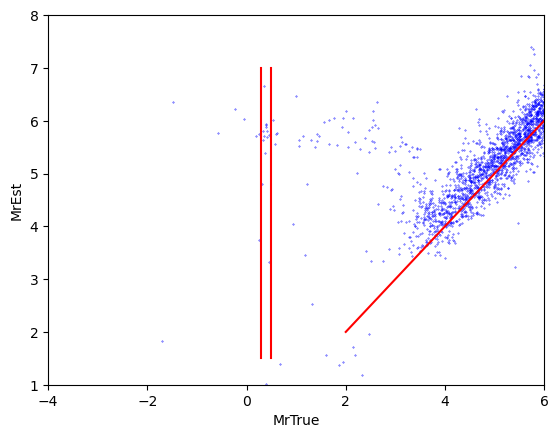

In [35]:
plt.scatter(catalog['Mr'], catalog['MrEst'], c='blue', s=0.1)  
plt.xlabel('MrTrue')
plt.ylabel('MrEst')
plt.plot([2,6], [2,6], c='red')
plt.xlim(-4, 6)
plt.ylim(1, 8)

plt.plot([0.3,0.3], [1.5, 7], c='red')
plt.plot([0.5,0.5], [1.5, 7], c='red')

In [36]:
%%timeit
catalog['tLoc'] = catalog['MrEst']
lt.getMrFromFeHtLoc(OKlocus, catalog)

1min 30s ± 921 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


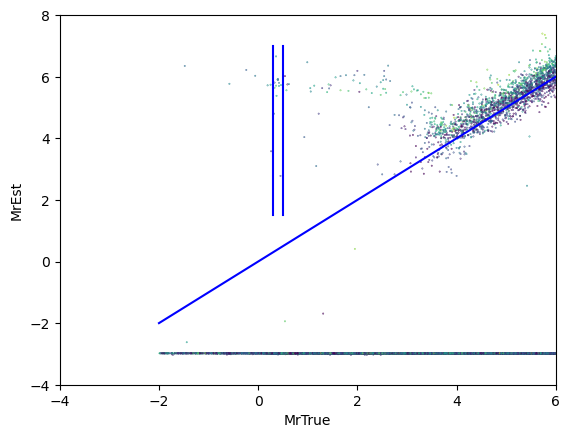

In [37]:
# test result
plt.scatter(catalog['Mr'], catalog['MrTrueEst'], c=catalog['FeH'], s=0.1)  
plt.xlabel('MrTrue')
plt.ylabel('MrEst')
plt.plot([-2,6], [-2,6], c='blue')
plt.xlim(-4, 6)
plt.ylim(-4, 8) 
plt.plot([0.3,0.3], [1.5, 7], c='blue')
plt.plot([0.5,0.5], [1.5, 7], c='blue')

In [38]:
# for processed stars
if (iEnd < iStart):
    iStart = 0
    iEnd = np.size(catalog)

In [39]:
## overwrite the first version of outfile
catalog['MrEst'] = catalog['MrTrueEst']
bt.writeBayesEstimates(catalog, outfile, iStart, iEnd, do3D=True)
print('made output file with', len(catalog), 'entries:')
print(outfile)

made output file with 619581 entries:
../../outputs/SDSSpatchRA340-350_BayesEstimates3D-fixedAr.txt


## more testing, should be moved elsewhere...

In [27]:
mytable = catalog[iStart:iEnd]
print('selected', len(mytable), ' from', len(catalog))

selected 619581  from 619581


In [28]:
has_nan = np.zeros(len(mytable), dtype=bool)
for col in mytable.itercols():
    if col.info.dtype.kind == 'f':
        has_nan |= np.isnan(col)
simsP = mytable[(~has_nan)&(mytable['chi2min']<100)&(mytable['FeHEstUnc']>0.001)]
bad = mytable[has_nan]
print('selected', len(simsP), ' from', len(mytable),' bad:', len(bad))

selected 617518  from 619581  bad: 949


In [29]:
simsP['dMr'] = simsP['Mr'] - simsP['MrEst']
simsP['dMrNorm'] = simsP['dMr'] / simsP['MrEstUnc'] 
simsP['dFeH'] = simsP['FeH'] - simsP['FeHEst']
simsP['dFeHNorm'] = simsP['dFeH'] / simsP['FeHEstUnc'] 
simsP['dAr'] = simsP['Ar'] - simsP['ArEst']
simsP['dArNorm'] = simsP['dAr'] / simsP['ArEstUnc'] 
print('sample size:', np.size(simsP))
print('Mr  FeH  Ar:')
print('median uncertainty:', np.median(simsP['MrEstUnc']), np.median(simsP['FeHEstUnc']), np.median(simsP['ArEstUnc']))
print('median error:', np.median(simsP['dMr']), np.median(simsP['dFeH']), np.median(simsP['dAr']))
print('std for chi:', np.std(simsP['dMrNorm']), np.std(simsP['dFeHNorm']), np.std(simsP['dArNorm']))
print('sigG for chi:', bt.sigGzi(simsP['dMrNorm']), bt.sigGzi(simsP['dFeHNorm']), bt.sigGzi(simsP['dArNorm']))

sample size: 617518
Mr  FeH  Ar:
median uncertainty: 0.2902717470434754 0.4099960080761461 0.008156320715260455
median error: 0.0 0.0722387112645333 3.947670644854906e-05
std for chi: 5.889701606895166 2.5563436757247535 0.3586886636259108
sigG for chi: 1.1192107519563324 1.1783110310284657 0.05632341951612564


In [30]:
# overwrite MrEst that are nan
has_nanCAT = np.zeros(len(catalog), dtype=bool)
for col in catalog.itercols():
    if col.info.dtype.kind == 'f':
        has_nanCAT |= np.isnan(col)
catalog['MrEst'] = np.where(has_nanCAT, 99.99, catalog['MrEst'])

### how clean and complete is the RG sample: MrEst < 3

In [31]:
McutRG = 3.0
RG = catalog[catalog['Mr']<McutRG]
#RG = catalog[catalog['Mr']<4]
RGcand = catalog[catalog['MrEst']<McutRG]
RGfn = RG[RG['MrEst']>McutRG]
RGcandOK = RGcand[RGcand['Mr']<McutRG]
print(len(RG), len(RGcand), len(RGcandOK))
print('      purity:', len(RGcandOK)/len(RGcand))
print('completeness:', len(RGcandOK)/len(RG))
print('False negatives, FeH, <rmag> and <Mr>:', np.median(RGfn['FeH']), np.median(RGfn['rmag']), np.median(RGfn['Mr']))
print('True positives,  FeH, <rmag> and <Mr>:', np.median(RGcandOK['FeH']), np.median(RGcandOK['rmag']), np.median(RGcandOK['Mr']))


6300 1779 1778
      purity: 0.9994378864530635
completeness: 0.2822222222222222
False negatives, FeH, <rmag> and <Mr>: -1.14 19.76 2.17
True positives,  FeH, <rmag> and <Mr>: -1.74 18.46 0.675


(17.0, -3.5)

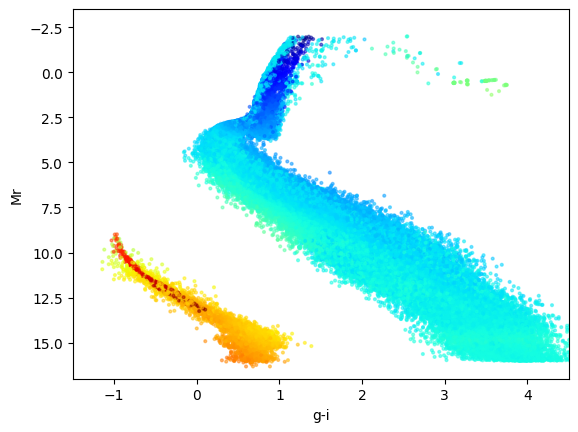

In [32]:
catalog['dMrBayes'] = catalog['Mr'] - catalog['MrTrueEst']

# test result
plt.scatter(catalog['gi0'], catalog['Mr'], c=catalog['dMrBayes'], cmap=plt.cm.jet, s=3.9, alpha=0.5)  
plt.xlabel('g-i')
plt.ylabel('Mr') 
plt.xlim(-1.5, 4.5)
plt.ylim(17, -3.5)  


In [33]:
msrgb = catalog[catalog['logg']<6.5]
msrgbOK = msrgb[msrgb['chi2min']<50]
msrgbOK2 = msrgbOK[np.abs(msrgbOK['dMrBayes'])<1.5]
msrgbBad = msrgb[msrgb['chi2min']>50]

print(len(catalog), len(msrgb), len(msrgbOK), len(msrgbOK2), len(msrgbBad))

619581 609882 609195 603087 687


(-2.0, 2.0)

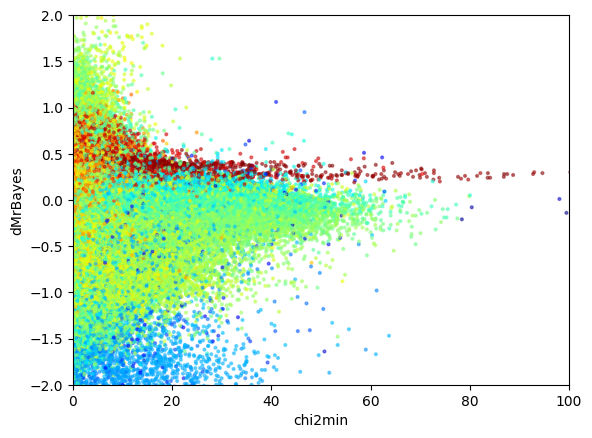

In [44]:
plt.scatter(msrgb['chi2min'], msrgb['dMrBayes'], c=msrgb['Mr'], cmap=plt.cm.jet, s=3.9, alpha=0.5)  
plt.xlabel('chi2min')
plt.ylabel('dMrBayes') 
plt.xlim(0, 100)
plt.ylim(-2, 2.0)  

(17.0, -3.5)

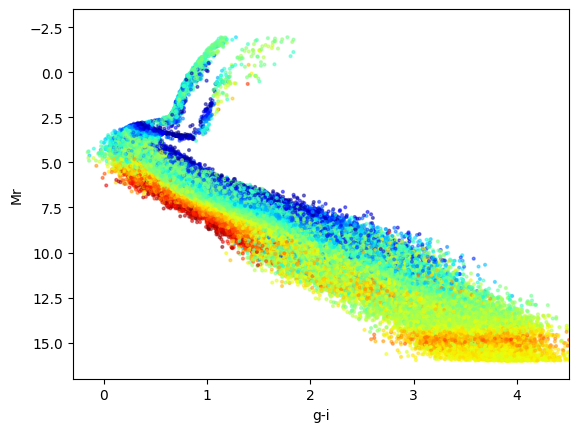

In [34]:
# test result
plt.scatter(msrgbOK2['gi0'], msrgbOK2['Mr'], c=msrgbOK2['dMrBayes'], cmap=plt.cm.jet, s=3.9, alpha=0.5)  
#plt.scatter(msrgbBad['gi0'], msrgbBad['Mr'], c=msrgbBad['dMrBayes'], cmap=plt.cm.jet, s=3.9, alpha=0.5)  
plt.xlabel('g-i')
plt.ylabel('Mr') 
plt.xlim(-0.3, 4.5)
plt.ylim(17, -3.5)  

(17.0, -3.5)

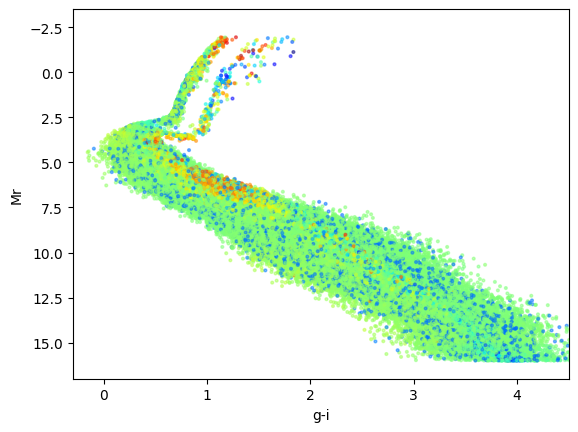

In [35]:
# test result
plt.scatter(msrgbOK2['gi0'], msrgbOK2['Mr'], c=msrgbOK2['Ar']-msrgbOK2['ArEst'], cmap=plt.cm.jet, s=3.9, alpha=0.5)  
#plt.scatter(msrgbBad['gi0'], msrgbBad['Mr'], c=msrgbBad['dMrBayes'], cmap=plt.cm.jet, s=3.9, alpha=0.5)  
plt.xlabel('g-i')
plt.ylabel('Mr') 
plt.xlim(-0.3, 4.5)
plt.ylim(17, -3.5)  

In [45]:
df = msrgbOK2
umagMax = 24     
df['dMr'] = df['Mr'] - df['MrEst']
df['dFeH'] = df['FeH'] - df['FeHEst']
df['dAr'] = df['Ar'] - df['ArEst']
lt.makeStatsTable3D(df, dMrname='dMr', dFeHname='dFeH', magName='umag', magThresh=umagMax, FeHthresh=-1.0, Mr1=4.0, Mr2=8.0)

---------------------------------------------------------------------------------------------------
      FULL SAMPLE:           dMr                      dFeH                         Ar
             all: ['0.000', '0.29', 603087] ['0.070', '0.38', 603087] ['0.000', '0.00', 603087]
    mag selected: ['-0.010', '0.12', 92010] ['0.051', '0.10', 92010] ['0.001', '0.00', 92010]
---------------------------------------------------------------------------------------------------
       low [FeH]:           dMr                  dFeH
             all: ['0.010', '0.10', 43843] ['0.037', '0.09', 43843] ['0.000', '0.00', 43843]
          giants: ['-0.060', '0.28', 7431] ['0.030', '0.11', 7431] ['0.000', '0.00', 7431]
         blue MS: ['0.010', '0.08', 35717] ['0.037', '0.09', 35717] ['0.001', '0.00', 35717]
          red MS: ['-0.030', '0.10', 695] ['0.121', '0.18', 695] ['0.001', '0.00', 695]
      high [FeH]:           dMr                  dFeH
             all: ['-0.030', '0.13', 48167] ['0.064

(-0.03, 0.03)

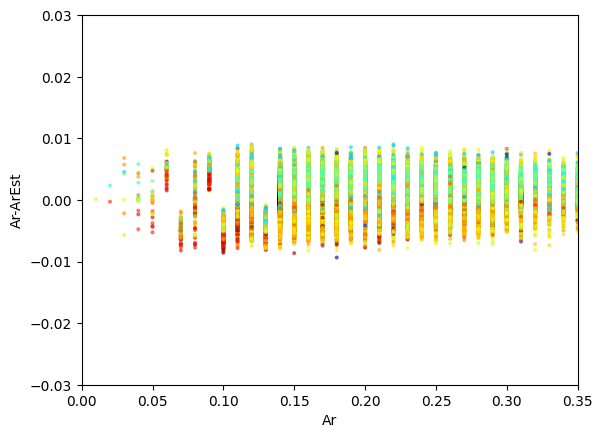

In [37]:
# test result
plt.scatter(msrgbOK2['Ar'], msrgbOK2['Ar']-msrgbOK2['ArEst'], c=msrgbOK2['Mr'], cmap=plt.cm.jet, s=3.9, alpha=0.5)  
plt.xlabel('Ar')
plt.ylabel('Ar-ArEst') 
plt.xlim(0, 0.35)
plt.ylim(-0.03, 0.03)  

(-2.5, 0.5)

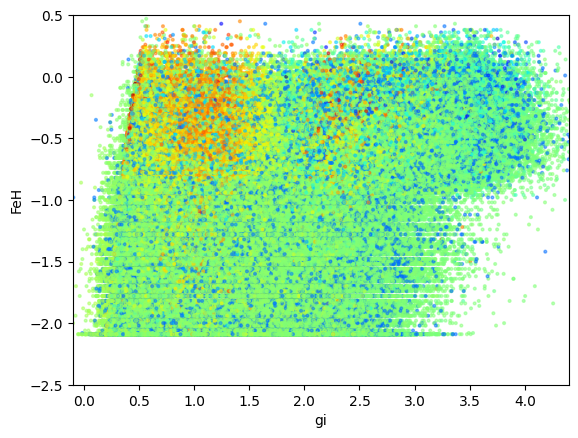

In [38]:
# test result
plt.scatter(msrgbOK2['gi0'], msrgbOK2['FeH'], c=msrgbOK2['Ar']-msrgbOK2['ArEst'], cmap=plt.cm.jet, s=3.9, alpha=0.5)  
plt.xlabel('gi')
plt.ylabel('FeH') 
plt.xlim(-0.1, 4.4)
plt.ylim(-2.5, 0.5)  

In [40]:
np.max(catalog['logg'])

8.5